In [1]:
!pip install prince


  Using cached pandas-2.2.3-cp39-cp39-macosx_10_9_x86_64.whl (12.6 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3


In [2]:
pip install pandas==1.5.3


  Using cached pandas-1.5.3-cp39-cp39-macosx_10_9_x86_64.whl (12.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prince 0.14.0 requires pandas<3.0.0,>=2.2.0, but you have pandas 1.5.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
get_ipython().system('pip install factor-analyzer')


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
from factor_analyzer import FactorAnalyzer
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from prince import MCA
from scipy import stats


from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline


In [5]:
# Configuración de visualización
plt.style.use('seaborn')
sns.set_palette('viridis')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)


In [6]:
# Cargar todos los archivos disponible
pop = pd.read_csv('pop.csv')
artist_pop = pd.read_csv('artist_pop.csv')

In [7]:
# Verificación básica de los datos
def check_dataframes(df_list, names):
    for df, name in zip(df_list, names):
        print(f"\n=== {name.upper()} ===")
        print(f"Dimensiones: {df.shape}")
        print("\nPrimeras filas:")
        print(df.head(2))
        print("\nTipos de datos y nulos:")
        print(pd.concat([df.dtypes, df.isnull().sum()], axis=1).rename(columns={0: 'Tipo', 1: 'Nulos'}))
        print("\nEstadísticas descriptivas:")
        print(df.describe(include='all'))

In [8]:

check_dataframes(
    [pop, artist_pop],
    ["pop", "artist_pop"]
)


=== POP ===
Dimensiones: (298, 9)

Primeras filas:
         genres  acousticness  danceability  duration_ms     energy  \
0  acoustic pop     49.023503     53.510832   235.379784  47.643992   
1    afghan pop     41.062857     65.171429   326.503929  65.157143   

    liveness  speechiness    valence   popularity  
0  15.775050     4.177066  37.941535  5311.550475  
1   8.746071     8.441429  78.410714  3932.142857  

Tipos de datos y nulos:
                 Tipo  Nulos
genres         object      0
acousticness  float64      0
danceability  float64      0
duration_ms   float64      0
energy        float64      0
liveness      float64      0
speechiness   float64      0
valence       float64      0
popularity    float64      0

Estadísticas descriptivas:
              genres  acousticness  danceability  duration_ms      energy  \
count            298    298.000000    298.000000   298.000000  298.000000   
unique           298           NaN           NaN          NaN         NaN   
top 

In [9]:
def basic_cleaning(df):
    """
    Limpieza básica del DataFrame que maneja columnas con listas.
    """
    # Primero hacer una copia para no modificar el original
    df = df.copy()
    
    # Eliminar columnas completamente vacías
    df = df.dropna(axis=1, how='all')
    
    # Verificar si hay columnas que contienen listas
    list_columns = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, list)).any()]
    
    if not list_columns:
        # Si no hay columnas con listas, proceder normalmente
        df = df.drop_duplicates()
    else:
        # Si hay columnas con listas, convertirlas a string temporalmente para drop_duplicates
        for col in list_columns:
            df[col] = df[col].astype(str)
        
        df = df.drop_duplicates()
        
        # Revertir la conversión a string
        for col in list_columns:
            df[col] = df[col].apply(ast.literal_eval)
    
    return df

In [10]:
def univariate_numeric_analysis(df, df_name=""):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns

    print(f"\n=== ANÁLISIS UNIVARIADO NUMÉRICO ({df_name.upper()}) ===")

    summary = df[num_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
    summary['IQR'] = summary['75%'] - summary['25%']
    summary['Outlier Superior'] = summary['75%'] + 1.5 * summary['IQR']
    summary['Outlier Inferior'] = summary['25%'] - 1.5 * summary['IQR']
    print("\nEstadísticas descriptivas extendidas:")
    print(summary)

    for col in num_cols:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribución de {col}')

        plt.subplot(1, 3, 2)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')

        plt.subplot(1, 3, 3)
        stats.probplot(df[col].dropna(), plot=plt)
        plt.title(f'QQ-plot de {col}')

        plt.tight_layout()
        plt.show()


=== ANÁLISIS UNIVARIADO NUMÉRICO (POP) ===

Estadísticas descriptivas extendidas:
              count         mean          std        min          1%  \
acousticness  298.0    36.356611    24.843204   0.089497    0.286250   
danceability  298.0    58.774022    10.527672  27.641667   31.789467   
duration_ms   298.0   234.386753    49.704035  42.813000  145.620145   
energy        298.0    59.126438    16.211049  15.478750   20.388000   
liveness      298.0    18.352139     7.478935   5.670000    5.900000   
speechiness   298.0     6.565360     4.394142   2.580000    2.877900   
valence       298.0    54.191499    16.837141   3.930000   16.761336   
popularity    298.0  4550.391949  1663.714080   0.000000    0.000000   

                      5%          25%          50%          75%          95%  \
acousticness    4.180478    17.047239    32.282161    53.761942    82.784206   
danceability   41.801278    52.457347    58.879167    65.499663    75.699354   
duration_ms   173.446401   2

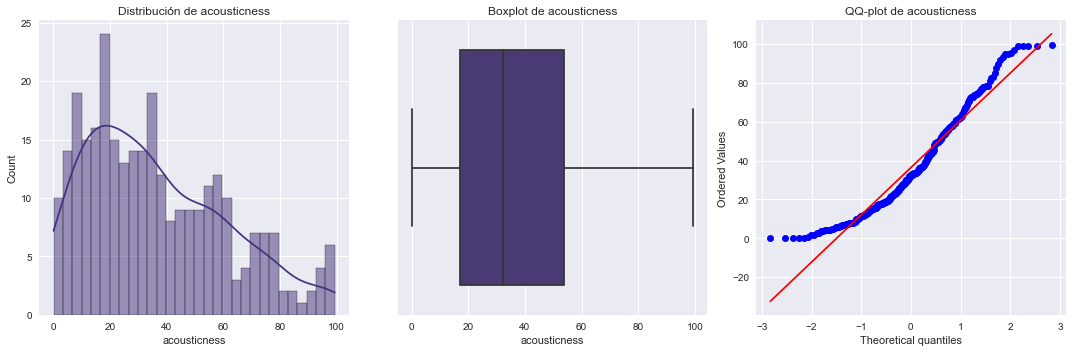

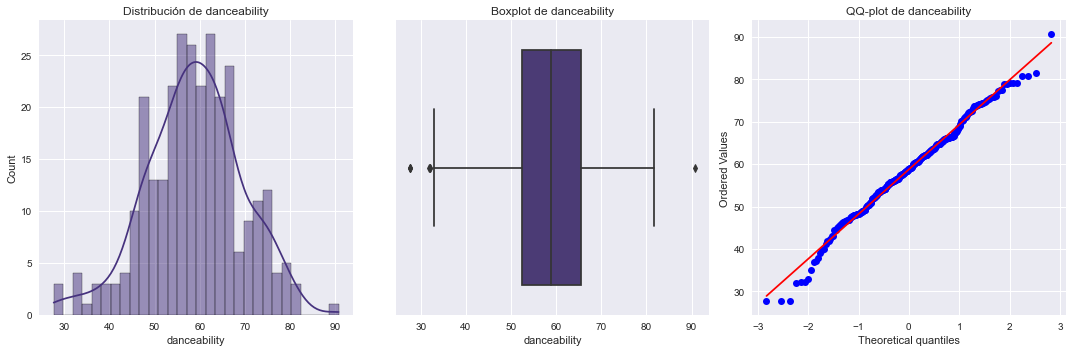

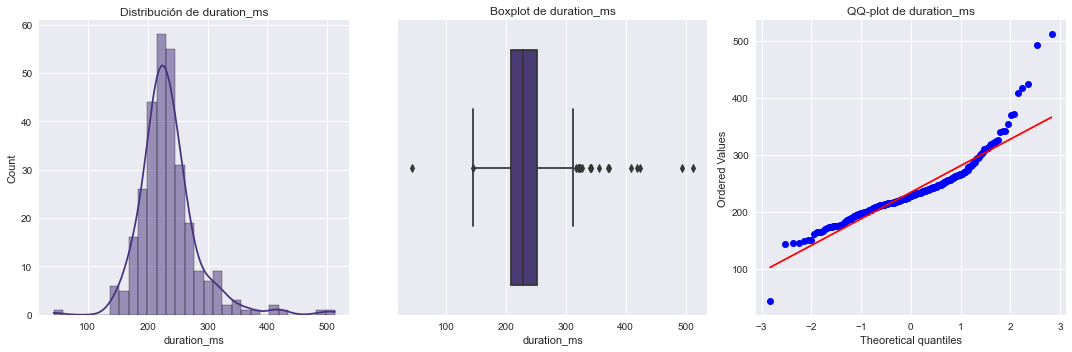

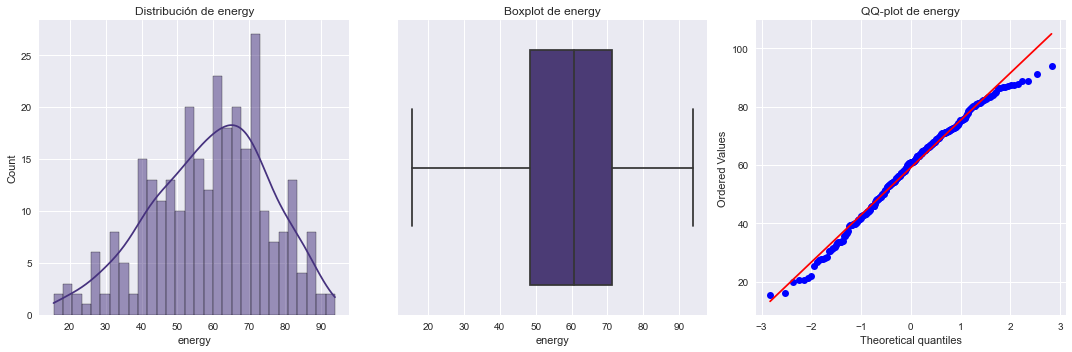

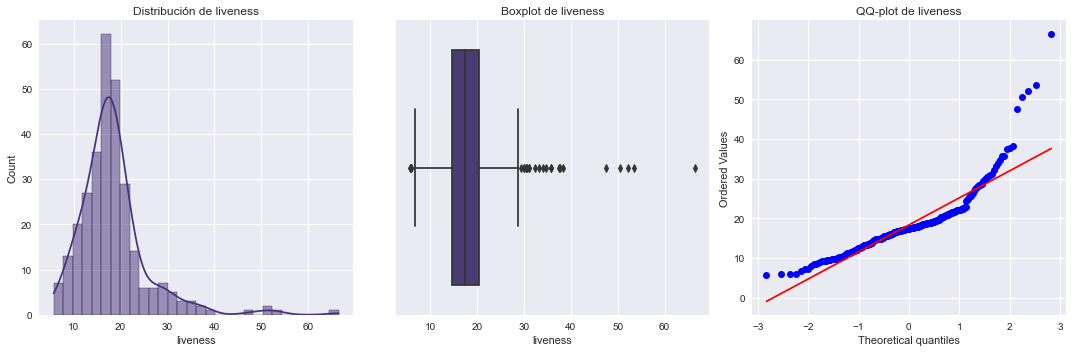

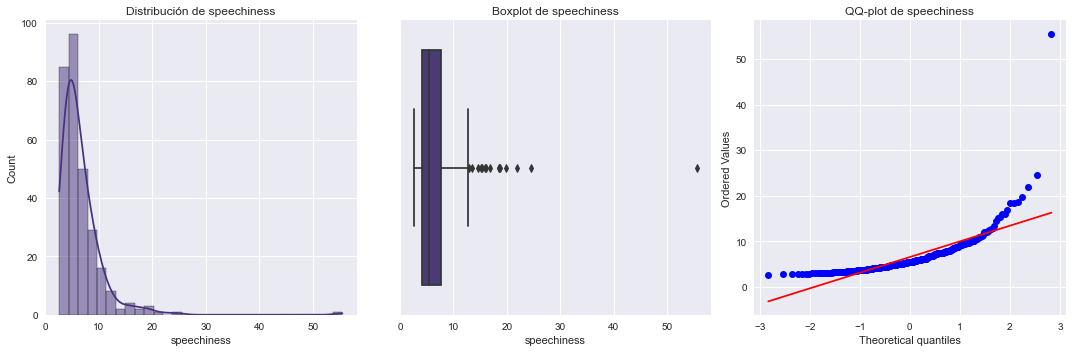

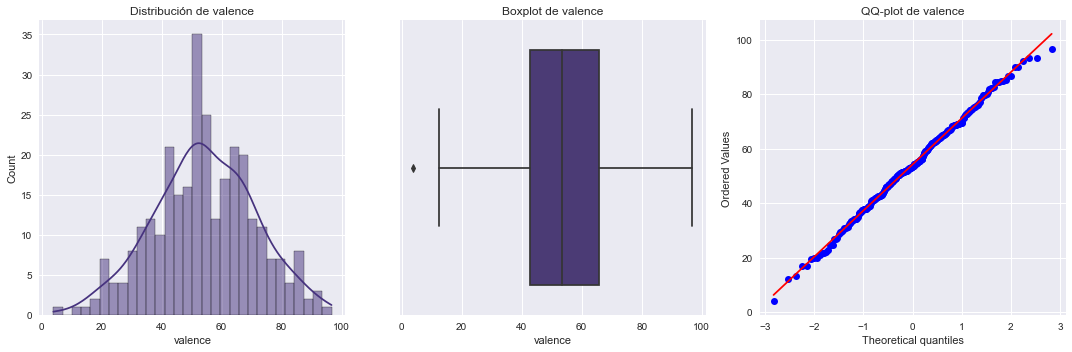

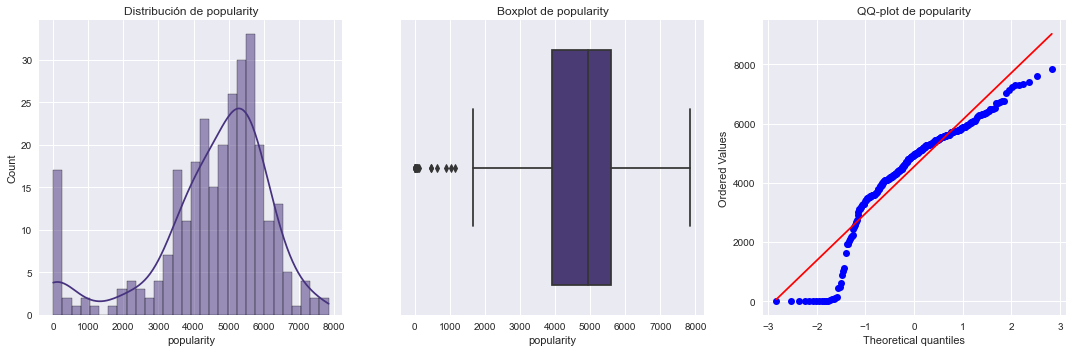


=== ANÁLISIS UNIVARIADO NUMÉRICO (POP_ARTISTA) ===

Estadísticas descriptivas extendidas:
               count         mean          std     min        1%           5%  \
acousticness  5482.0    30.995622    28.075120   0.000    0.0000     0.000000   
danceability  5482.0    59.069865    13.679658  11.000   24.0000    36.000000   
duration_ms   5482.0   229.901336    59.844049  42.813  120.8322   153.137475   
energy        5482.0    61.393287    19.877659   0.000   12.8100    25.000000   
liveness      5482.0    18.605983    10.996632   2.000    5.0000     7.000000   
speechiness   5482.0     7.568588     7.022609   2.000    3.0000     3.000000   
valence       5482.0    53.459869    20.355317   3.000    8.8100    19.000000   
popularity    5482.0  4863.204123  1573.358614   0.000    0.0000  1865.500000   

                      25%        50%          75%        95%          99%  \
acousticness     7.000000    22.0000    50.000000    88.0000    99.000000   
danceability    50.000000

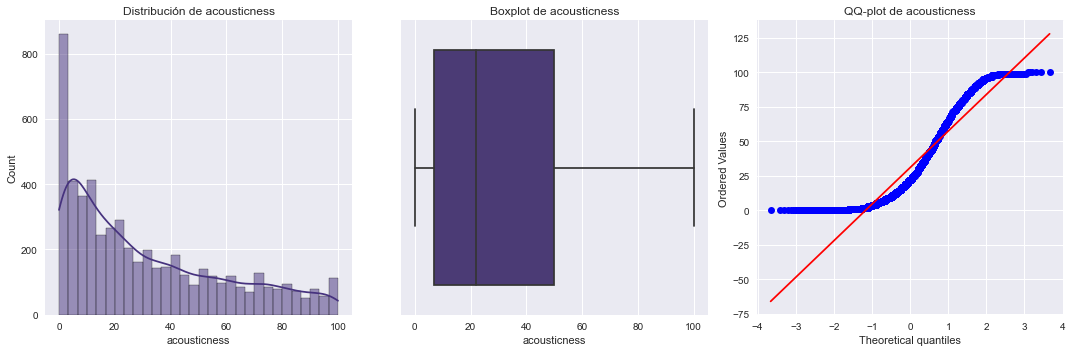

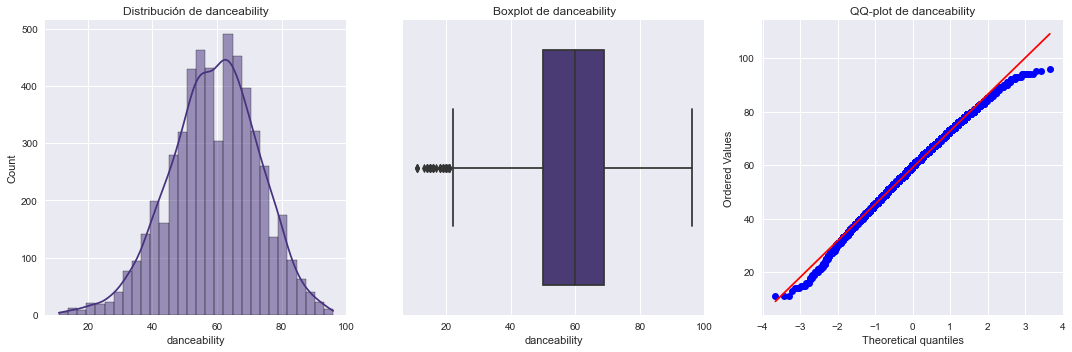

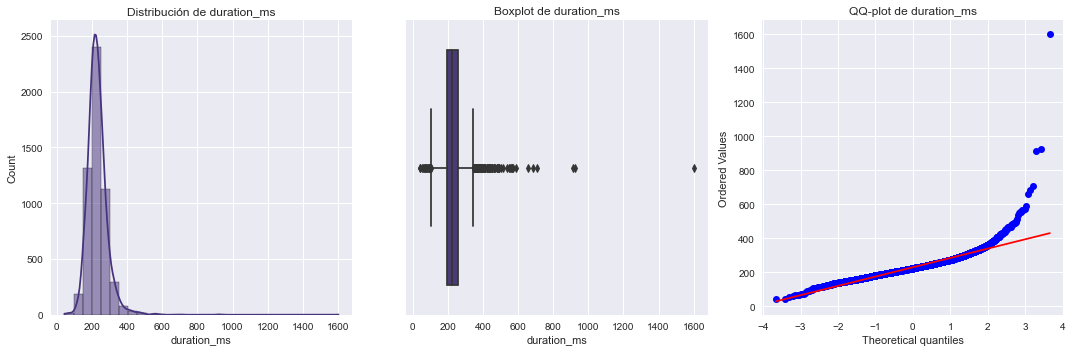

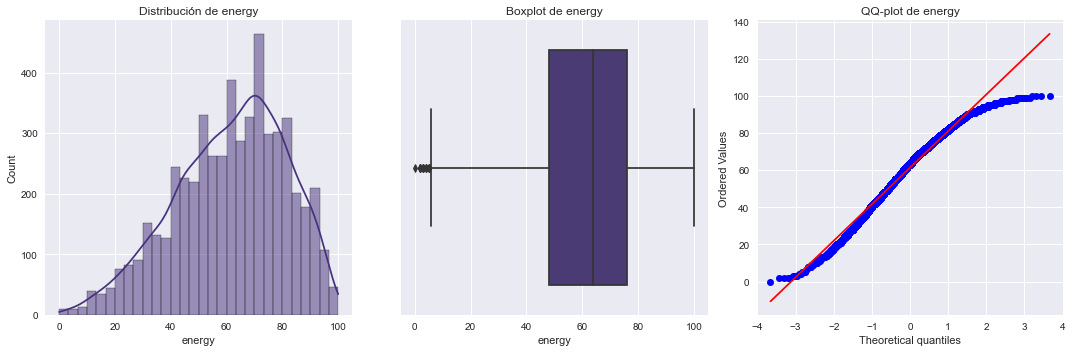

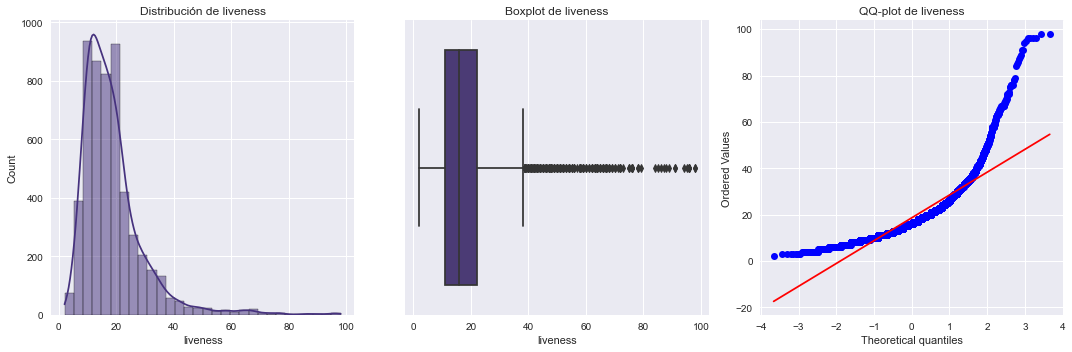

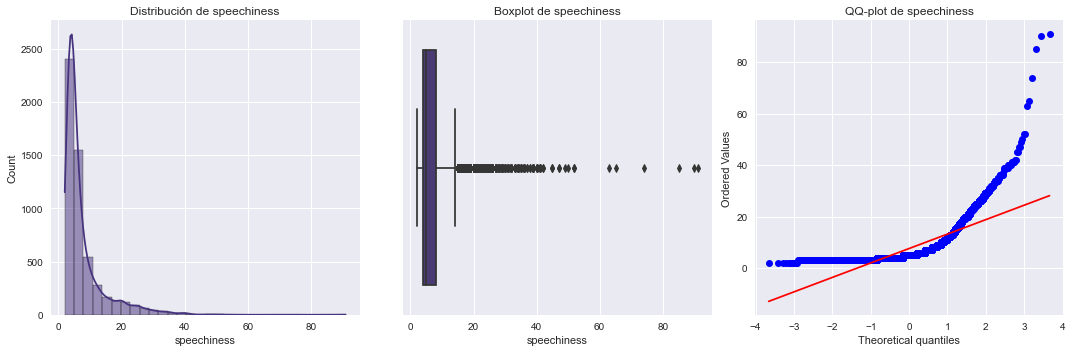

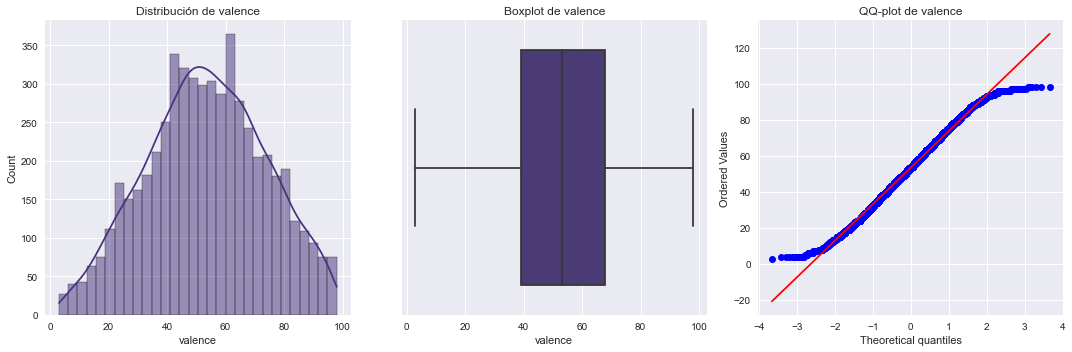

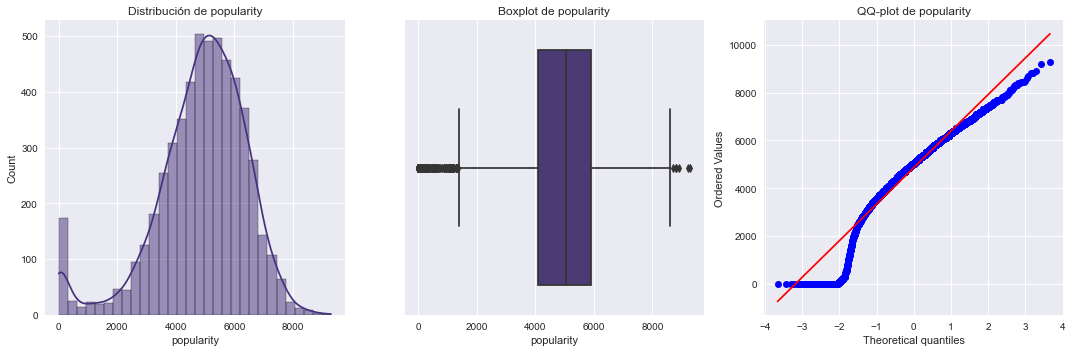

In [11]:
# Aplicar a los dataframes principales
univariate_numeric_analysis(pop, "pop")
univariate_numeric_analysis(artist_pop, "pop_artista")


In [12]:
def univariate_categorical_analysis(df, cat_cols=None, df_name=""):
    if cat_cols is None:
        cat_cols = df.select_dtypes(include=['object', 'category']).columns
    print(f"\n=== ANÁLISIS UNIVARIADO CATEGÓRICO ({df_name.upper()}) ===")
    for col in cat_cols:
        # Para columnas con muchas categorías, mostrar solo las principales
        if df[col].nunique() > 20:
            top_values = df[col].value_counts().head(20)
            print(f"\nTop 20 valores para {col}:")
            print(top_values)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(x=top_values.values, y=top_values.index)
            plt.title(f'Top 20 valores - {col}')
            plt.show()
        else:
            value_counts = df[col].value_counts(dropna=False)
            print(f"\nDistribución para {col}:")
            print(value_counts)
            
            plt.figure(figsize=(10, 6))
            if df[col].nunique() > 5:
                sns.barplot(x=value_counts.values, y=value_counts.index)
            else:
                plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
            plt.title(f'Distribución de {col}')
            plt.show()
# Aplicar a columnas categóricas relevantes
univariate_categorical_analysis(pop, cat_cols=['key', 'mode'], df_name="canciones individuales")
univariate_categorical_analysis(artist_pop, cat_cols=['genres'], df_name="con géneros")


=== ANÁLISIS UNIVARIADO CATEGÓRICO (CANCIONES INDIVIDUALES) ===


KeyError: 'key'

In [13]:
print(pop.columns)

Index(['genres', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'liveness', 'speechiness', 'valence', 'popularity'],
      dtype='object')


In [14]:
def genre_specific_analysis(df, genre_col='genres'):
    top_genres = df[genre_col].value_counts().head(20)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_genres.values, y=top_genres.index)
    plt.title('Top 20 Géneros Musicales')
    plt.xlabel('Número de apariciones')
    plt.ylabel('Género')
    plt.show()

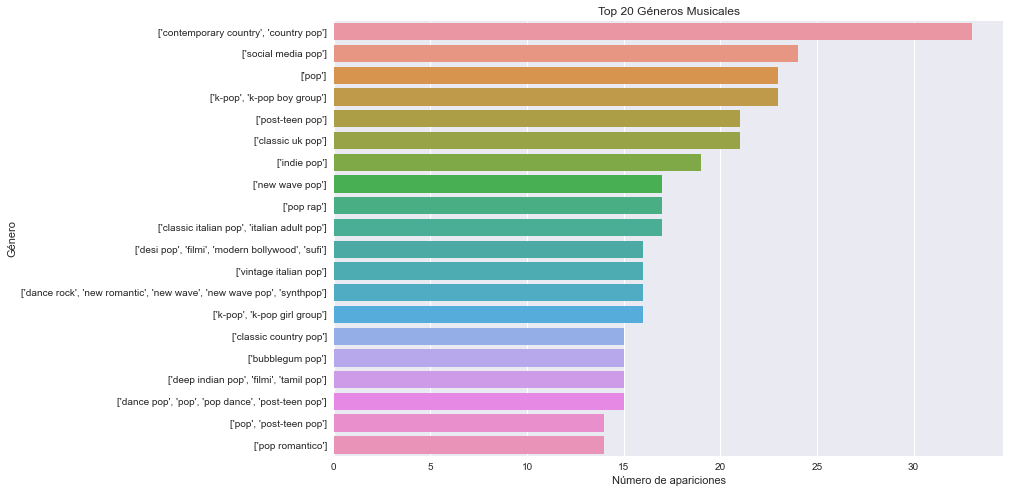

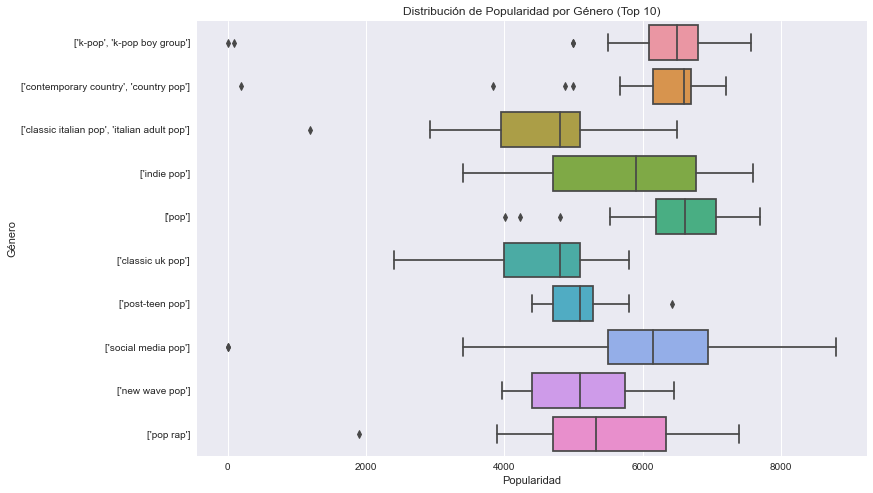

KeyError: "Columns not found: 'tempo', 'loudness'"

In [15]:
def genre_specific_analysis(df, genre_col='genres'):
    # Top géneros
    top_genres = df[genre_col].value_counts().head(20)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_genres.values, y=top_genres.index)
    plt.title('Top 20 Géneros Musicales')
    plt.xlabel('Número de apariciones')
    plt.ylabel('Género')
    plt.show()
    
    # Distribución de popularidad por género (top 10)
    top_10_genres = top_genres.index[:10]
    df_top_genres = df[df[genre_col].isin(top_10_genres)]
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_top_genres, y=genre_col, x='popularity')
    plt.title('Distribución de Popularidad por Género (Top 10)')
    plt.xlabel('Popularidad')
    plt.ylabel('Género')
    plt.show()
    
    # Atributos musicales promedio por género
    attributes = ['danceability', 'energy', 'valence', 'acousticness', 'loudness', 'tempo']
    genre_means = df_top_genres.groupby(genre_col)[attributes].mean()
    
    # Normalizar para comparación
    genre_means_norm = genre_means.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(genre_means_norm.T, annot=True, cmap='YlOrRd', fmt='.2f')
    plt.title('Atributos Musicales Normalizados por Género (Top 10)')
    plt.xlabel('Género')
    plt.ylabel('Atributo')
    plt.show()

genre_specific_analysis(artist_pop)


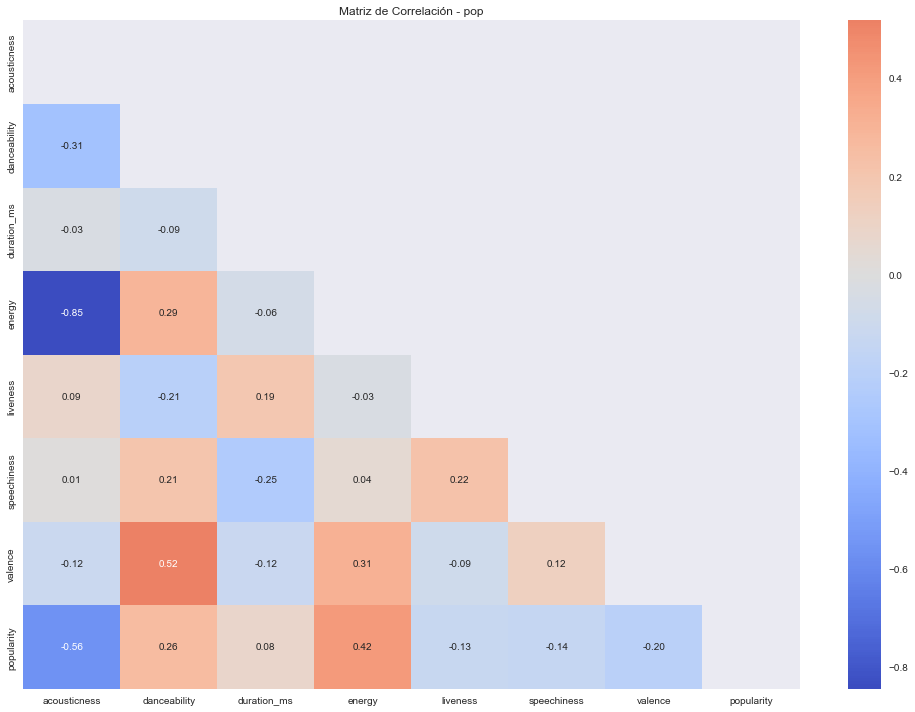


Top 5 correlaciones positivas:
valence       danceability    0.517692
danceability  valence         0.517692
popularity    energy          0.418196
energy        popularity      0.418196
valence       energy          0.311824
dtype: float64

Top 5 correlaciones negativas:
acousticness  energy         -0.845359
energy        acousticness   -0.845359
popularity    acousticness   -0.561438
acousticness  popularity     -0.561438
              danceability   -0.309100
dtype: float64


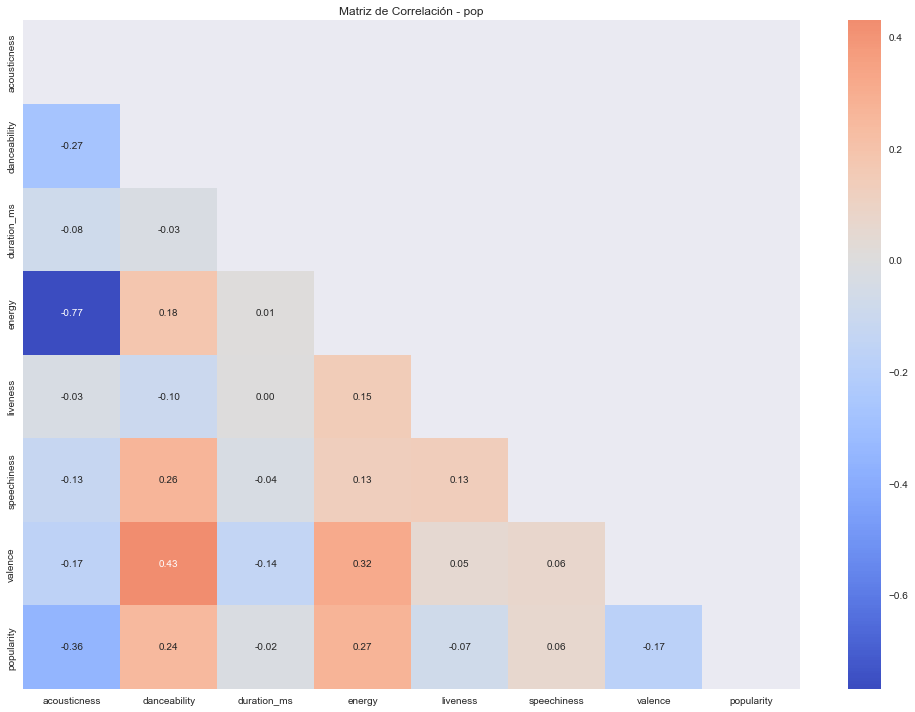


Top 5 correlaciones positivas:
valence       danceability    0.429181
danceability  valence         0.429181
valence       energy          0.315125
energy        valence         0.315125
              popularity      0.271708
dtype: float64

Top 5 correlaciones negativas:
acousticness  energy         -0.768160
energy        acousticness   -0.768160
popularity    acousticness   -0.357356
acousticness  popularity     -0.357356
              danceability   -0.269499
dtype: float64


In [22]:
def plot_correlation_analysis(df, title=""):
    # Seleccionar solo columnas numéricas
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Matriz de correlación
    corr_matrix = df[num_cols].corr()
    
    # Heatmap de correlación
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f',
                mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
    plt.title(f'Matriz de Correlación - {title}')
    plt.tight_layout()
    plt.show()
    
    # Top correlaciones positivas y negativas
    corr_unstacked = corr_matrix.unstack()
    corr_unstacked = corr_unstacked[corr_unstacked != 1]  # Eliminar correlación consigo mismo
    top_pos = corr_unstacked.sort_values(ascending=False).head(5)
    top_neg = corr_unstacked.sort_values().head(5)
    
    print("\nTop 5 correlaciones positivas:")
    print(top_pos)
    print("\nTop 5 correlaciones negativas:")
    print(top_neg)

# Aplicar a los datos principales
plot_correlation_analysis(pop, "pop")
plot_correlation_analysis(artist_pop, "pop")

In [21]:
import os
print(os.getcwd())


/Users/bernardopr/Documents/ITAM/8vo semestre/Aplicada 3/Proyecti Final


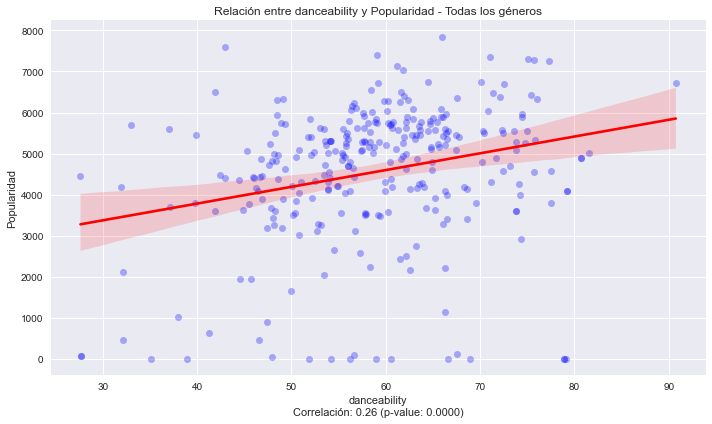

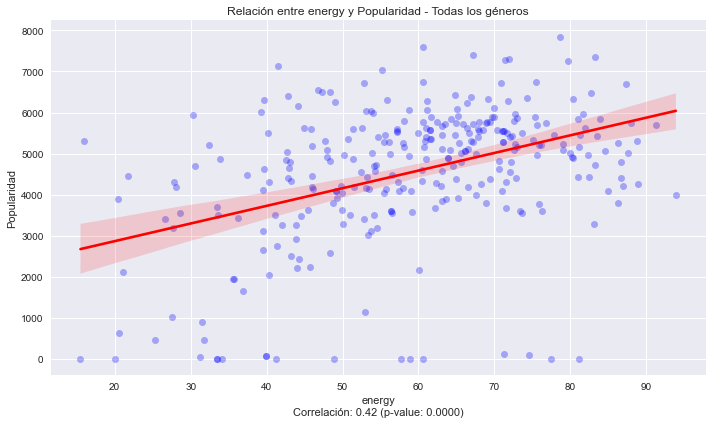

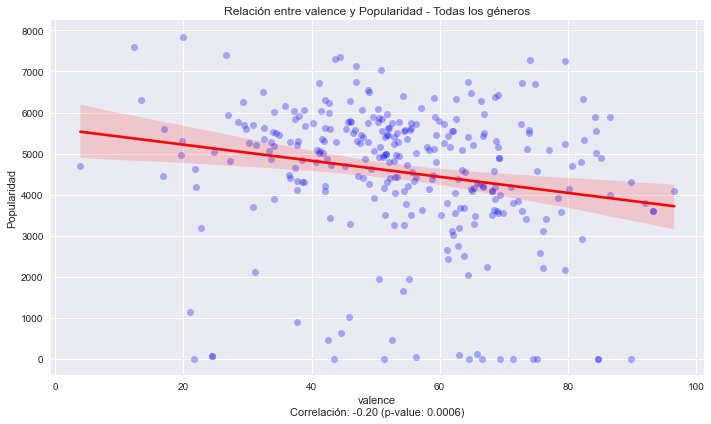

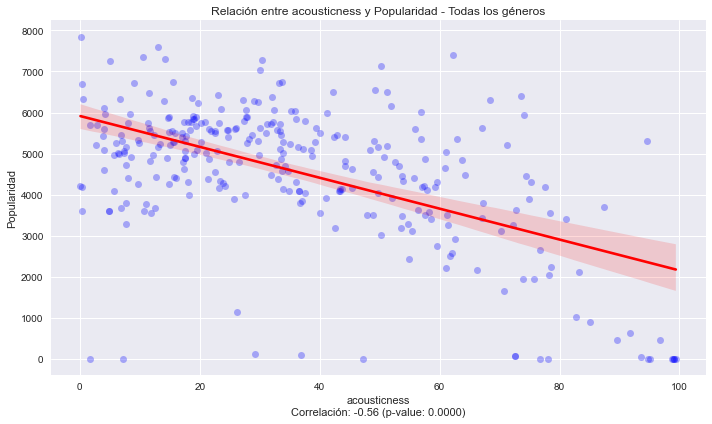

KeyError: 'loudness'

<Figure size 720x432 with 0 Axes>

In [23]:
def popularity_analysis(df, genre_filter=None, title=""):
    if genre_filter is not None and 'genres' in df.columns:
        df = df[df['genres'].isin(genre_filter)]
    
    # Variables a analizar contra popularidad
    attributes = ['danceability', 'energy', 'valence', 'acousticness', 
                 'loudness', 'tempo', 'speechiness', 'instrumentalness']
    
    for attr in attributes:
        # Gráfico de dispersión con línea de regresión
        plt.figure(figsize=(10, 6))
        sns.regplot(data=df, x=attr, y='popularity', 
                   scatter_kws={'alpha': 0.3, 'color': 'blue'},
                   line_kws={'color': 'red'})
        plt.title(f'Relación entre {attr} y Popularidad - {title}')
        
        # Calcular correlación y p-value
        corr, p_value = stats.pearsonr(df[attr].dropna(), df['popularity'].dropna())
        plt.xlabel(f'{attr}\nCorrelación: {corr:.2f} (p-value: {p_value:.4f})')
        plt.ylabel('Popularidad')
        plt.tight_layout()
        plt.show()

# Análisis general
popularity_analysis(pop, title="Todas los géneros")

# Análisis por género (top 5 géneros)
top_genres = artist_pop['genres'].value_counts().head(5).index
popularity_analysis(artist_pop, genre_filter=top_genres, title="Top 5 Géneros")

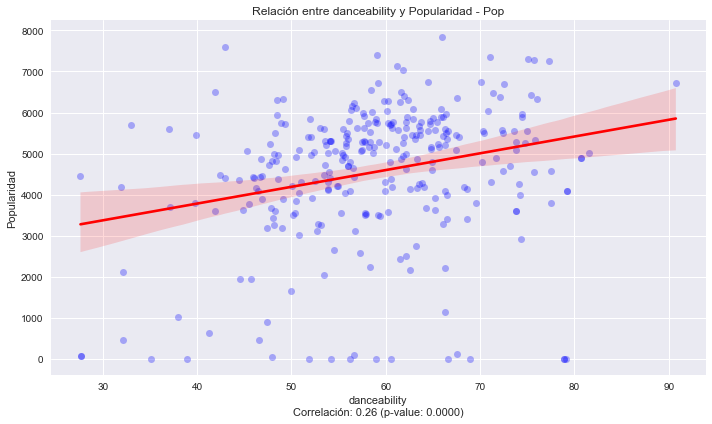

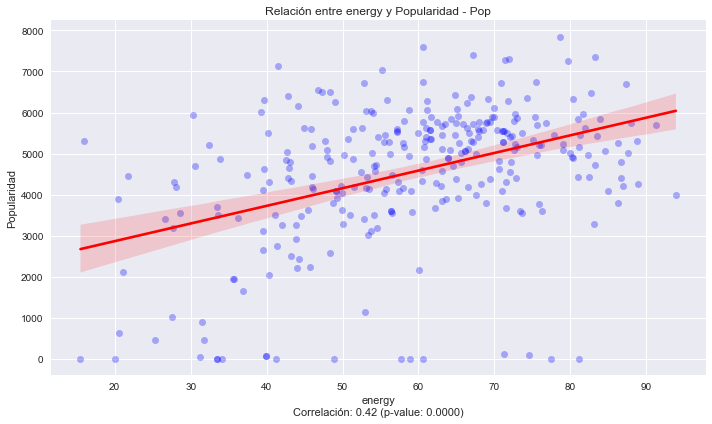

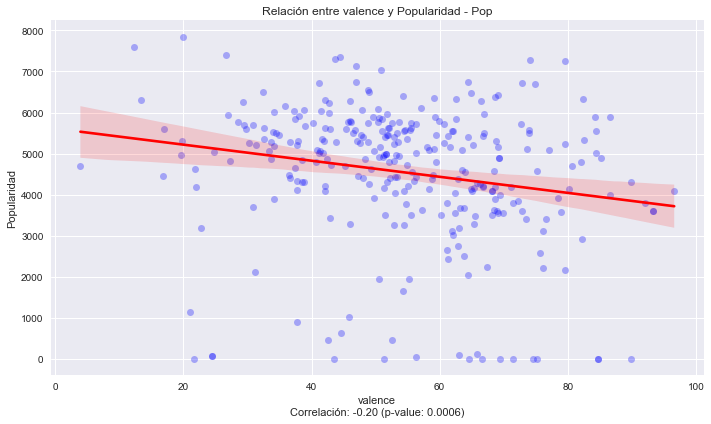

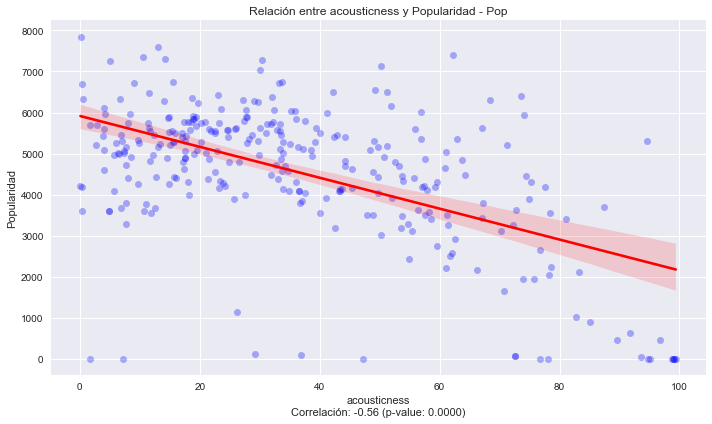

KeyError: 'loudness'

<Figure size 720x432 with 0 Axes>

In [24]:
# Análisis general
popularity_analysis(pop, title="Pop")

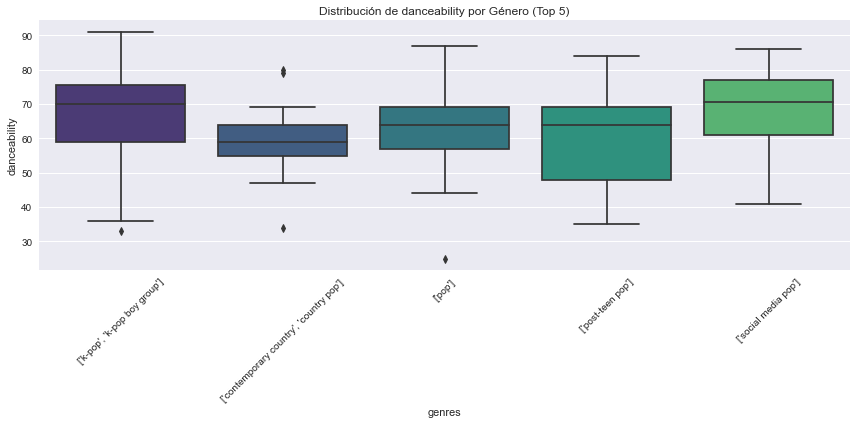

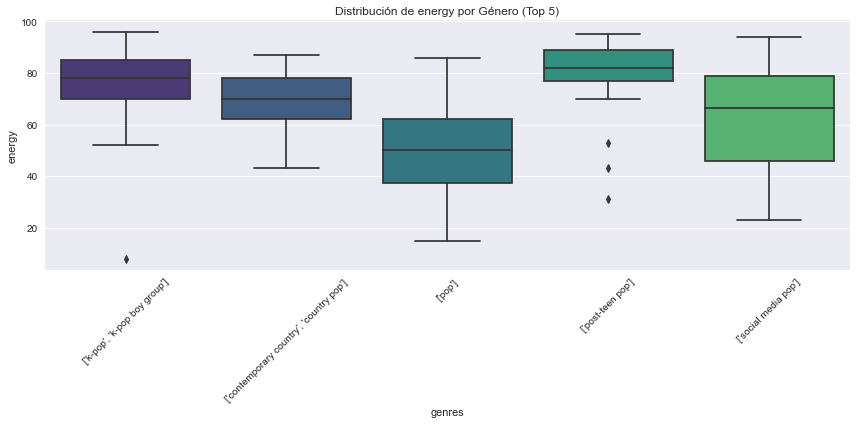

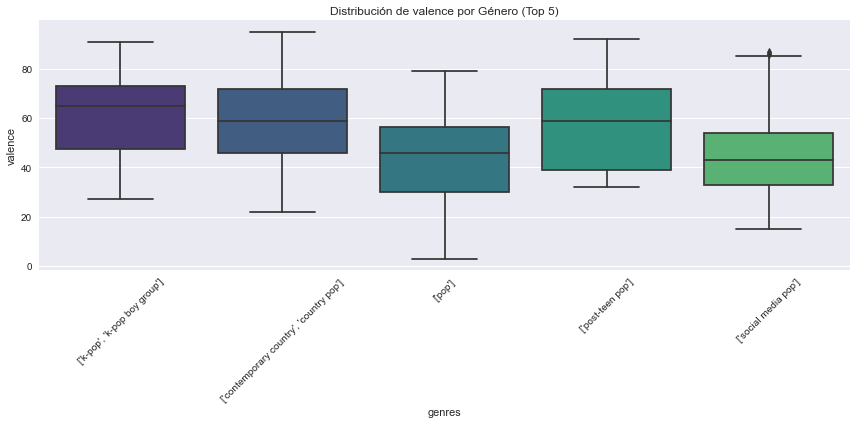

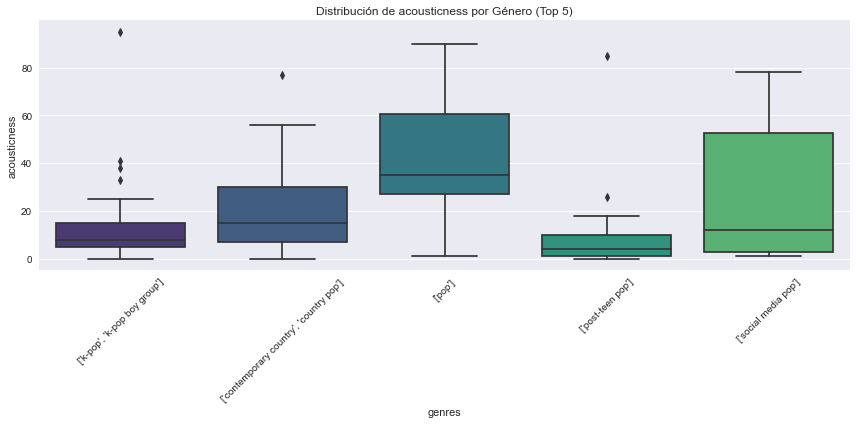

ValueError: Could not interpret input 'loudness'

<Figure size 864x432 with 0 Axes>

In [25]:
def genre_comparison(df, top_n=5):
    # Seleccionar géneros más comunes
    top_genres = df['genres'].value_counts().head(top_n).index
    df_top = df[df['genres'].isin(top_genres)]
    
    # Atributos a comparar
    attributes = ['danceability', 'energy', 'valence', 'acousticness', 'loudness']
    
    # Boxplots por género
    for attr in attributes:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df_top, x='genres', y=attr)
        plt.title(f'Distribución de {attr} por Género (Top {top_n})')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Violin plots combinados
    plt.figure(figsize=(14, 8))
    sns.violinplot(data=df_top.melt(id_vars=['genres'], value_vars=attributes, 
                                  var_name='attribute', value_name='value'),
                  x='attribute', y='value', hue='genres',
                  split=True, inner='quartile', palette='Set2')
    plt.title(f'Comparación de Atributos Musicales por Género (Top {top_n})')
    plt.xlabel('Atributo Musical')
    plt.ylabel('Valor')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

genre_comparison(artist_pop)

In [26]:
def radar_chart_genre_comparison(df, top_n=5):
    # Seleccionar géneros y atributos
    top_genres = df['genres'].value_counts().head(top_n).index
    attributes = ['danceability', 'energy', 'valence', 'acousticness', 
                 'speechiness', 'instrumentalness', 'liveness']
    
    # Preparar datos
    genre_means = df[df['genres'].isin(top_genres)].groupby('genres')[attributes].mean()
    genre_means_norm = genre_means.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
    
    # Configuración del radar chart
    angles = np.linspace(0, 2 * np.pi, len(attributes), endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el círculo
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Dibujar cada género
    for genre, row in genre_means_norm.iterrows():
        values = row.values.tolist()
        values += values[:1]  # Cerrar el círculo
        ax.plot(angles, values, linewidth=2, label=genre)
        ax.fill(angles, values, alpha=0.25)
    
    # Configuración visual
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), attributes)
    ax.set_title('Comparación Multivariada de Géneros Musicales', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()
radar_chart_genre_comparison(artist_pop)

KeyError: "Columns not found: 'instrumentalness'"

In [27]:
def mode_analysis(df):
    if 'mode' not in df.columns:
        print("No hay columna 'mode' en el DataFrame")
        return
    
    # Atributos a comparar
    attributes = ['danceability', 'energy', 'valence', 'acousticness']
    
    # Boxplots por modo
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df.melt(id_vars=['mode'], value_vars=attributes,
                           var_name='attribute', value_name='value'),
               x='attribute', y='value', hue='mode')
    plt.title('Distribución de Atributos por Modo (Major/Minor)')
    plt.xlabel('Atributo Musical')
    plt.ylabel('Valor')
    plt.legend(title='Mode')
    plt.show()
    
    # Test estadísticos
    print("\nResultados de tests t (modo major vs minor):")
    for attr in attributes:
        major = df[df['mode'] == 1][attr].dropna()
        minor = df[df['mode'] == 0][attr].dropna()
        t_stat, p_value = stats.ttest_ind(major, minor)
        print(f"{attr}: t = {t_stat:.2f}, p = {p_value:.4f}")

mode_analysis(pop)

No hay columna 'mode' en el DataFrame


In [39]:
def perform_pca_analysis(df, n_components=3, hue_column=None, sample_size=5000):
    """Realiza análisis PCA con visualización 2D, 3D y biplot."""
    
    # Seleccionar variables numéricas
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if hue_column in num_cols:
        num_cols = num_cols.drop(hue_column)
    
    # Muestreo si el dataset es muy grande
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)
    
    # Escalar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[num_cols])
    
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_scaled)
    
    # Crear DataFrame con resultados
    pca_df = pd.DataFrame(data=principal_components, 
                         columns=[f'PC{i+1}' for i in range(n_components)])
    
    if hue_column is not None:
        pca_df[hue_column] = df[hue_column].values
    
    # Visualización 2D
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=hue_column, alpha=0.7, palette='tab10')
    plt.title('PCA - Visualización 2D')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    # Visualización 3D interactiva
    if n_components >= 3:
        fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3',
                           color=hue_column if hue_column else None,
                           title='PCA - Visualización 3D',
                           labels={
                               'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
                               'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
                               'PC3': f'PC3 ({pca.explained_variance_ratio_[2]:.1%})'
                           })
        fig.show()
    
    # Biplot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=hue_column, alpha=0.6, palette='tab10')
    
    # Añadir vectores de características
    for i, feature in enumerate(num_cols):
        plt.arrow(0, 0, 
                  pca.components_[0, i] * 3, 
                  pca.components_[1, i] * 3,
                  color='black', alpha=0.7, head_width=0.05)
        plt.text(pca.components_[0, i] * 3.2,
                 pca.components_[1, i] * 3.2,
                 feature, fontsize=10, color='black')
    
    plt.title('Biplot PCA')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.grid(True)
    plt.show()
    
    # Resultados estadísticos
    print("\nVarianza explicada por cada componente:")
    for i, var in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i+1}: {var:.2%}")
    
    print("\nCargas factoriales (loadings):")
    loadings = pd.DataFrame(pca.components_.T, 
                           columns=[f'PC{i+1}' for i in range(n_components)],
                           index=num_cols)
    print(loadings)
    
    return pca, pca_df

# Aplicar PCA al dataset completo
pca_model, pca_results = perform_pca_analysis(pop, hue_column='mode')

# Aplicar PCA al dataset por géneros (top 10)
top_genres = artist_pop['genres'].value_counts().head(10).index
genre_subset = artist_pop[artist_pop['genres'].isin(top_genres)]
perform_pca_analysis(genre_subset, hue_column='genres')


KeyError: 'mode'


Test de esfericidad de Bartlett: χ² = 846.70, p = 0.0000
KMO: 0.506
Advertencia: KMO < 0.6 - Los datos pueden no ser adecuados para EFA

Varianza explicada por cada factor:
                       Factor 1  Factor 2  Factor 3
Varianza               2.098520  1.262853  1.070947
Varianza Proporcional  0.262315  0.157857  0.133868
Varianza Acumulada     0.262315  0.420172  0.554040

Cargas factoriales:
              Factor 1  Factor 2  Factor 3
acousticness -0.985363 -0.069896  0.004684
danceability  0.304088  0.551550 -0.082483
duration_ms   0.050106 -0.247060  0.092004
energy        0.803805  0.256568  0.073301
liveness     -0.053695 -0.205136  0.979158
speechiness  -0.044420  0.276141  0.246026
valence       0.069336  0.821442  0.069080
popularity    0.613867 -0.183825 -0.161964


/Users/bernardopr/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


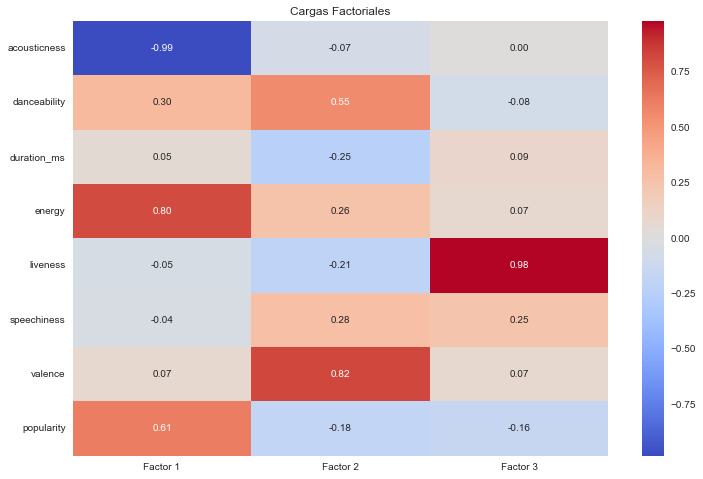

In [28]:
def perform_efa(df, n_factors=3, rotation='varimax'):
    """Realiza análisis factorial exploratorio."""
    
    # Seleccionar variables numéricas
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Verificar adecuación de los datos
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
    chi_square, p_value = calculate_bartlett_sphericity(df[num_cols])
    kmo_all, kmo_model = calculate_kmo(df[num_cols])
    
    print(f"\nTest de esfericidad de Bartlett: χ² = {chi_square:.2f}, p = {p_value:.4f}")
    print(f"KMO: {kmo_model:.3f}")
    
    if kmo_model < 0.6:
        print("Advertencia: KMO < 0.6 - Los datos pueden no ser adecuados para EFA")
    
    # Realizar EFA
    fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation)
    fa.fit(df[num_cols])
    
    # Resultados
    print("\nVarianza explicada por cada factor:")
    print(pd.DataFrame(fa.get_factor_variance(),
                      index=['Varianza', 'Varianza Proporcional', 'Varianza Acumulada'],
                      columns=[f'Factor {i+1}' for i in range(n_factors)]))
    
    print("\nCargas factoriales:")
    loadings = pd.DataFrame(fa.loadings_,
                           index=num_cols,
                           columns=[f'Factor {i+1}' for i in range(n_factors)])
    print(loadings)
    
    # Visualización de cargas factoriales
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Cargas Factoriales')
    plt.show()
    
    return fa

# Aplicar EFA
efa_model = perform_efa(pop)

In [33]:
def perform_clustering(df, max_clusters=10, hue_column=None, random_state=42):
    """
    Realiza clustering con K-Means con análisis de validación mejorado y visualización.
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame de pandas con los datos a analizar
    max_clusters : int, opcional (default=8)
        Número máximo de clusters a evaluar
    hue_column : str, opcional
        Nombre de la columna para usar como hue en visualizaciones
    random_state : int, opcional (default=42)
        Semilla para reproducibilidad
        
    Retorna:
    --------
    df_clustered : DataFrame
        DataFrame original con columna adicional 'cluster'
    kmeans : KMeans
        Modelo KMeans entrenado
    """
    
    # 1. Preparación de Datos
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if hue_column in num_cols:
        num_cols = num_cols.drop(hue_column)
    
    print(f"\nVariables utilizadas para clustering: {list(num_cols)}")
    
    # Escalado de datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[num_cols])
    
    # 2. Determinación del Número Óptimo de Clusters
    print("\n=== EVALUANDO NÚMERO ÓPTIMO DE CLUSTERS ===")
    
    wcss = []  # Within-Cluster-Sum-of-Squares
    silhouette_scores = []
    davies_bouldin_scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(X_scaled)
        
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
    # Gráficos de validación
    plt.figure(figsize=(15, 5))
    
    # Gráfico del Codo
    plt.subplot(1, 3, 1)
    plt.plot(range(2, max_clusters + 1), wcss, marker='o')
    plt.title('Método del Codo')
    plt.xlabel('Número de clusters')
    plt.ylabel('WCSS (Inercia)')
    
    # Gráfico de Silhouette
    plt.subplot(1, 3, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Puntaje de Silueta')
    plt.xlabel('Número de clusters')
    plt.ylabel('Score de Silueta')
    plt.axvline(np.argmax(silhouette_scores) + 2, color='red', linestyle='--')
    
    # Gráfico de Ratio WCSS
    plt.subplot(1, 3, 3)
    wcss_ratio = [wcss[i-1]/wcss[i] for i in range(1, len(wcss))]
    plt.plot(range(2, max_clusters + 1)[1:], wcss_ratio, marker='o')
    plt.title('Ratio de WCSS (k vs k+1)')
    plt.xlabel('Número de clusters')
    plt.ylabel('Ratio WCSS(k)/WCSS(k+1)')
    
    plt.tight_layout()
    plt.show()
    
    # Selección del número óptimo de clusters
    optimal_k = np.argmax(silhouette_scores) + 2  # +2 porque empezamos en k=2
    print(f"\nNúmero óptimo de clusters sugerido: {optimal_k}")
    print(f"Score de silueta para k={optimal_k}: {silhouette_scores[optimal_k-2]:.3f}")
    
    # 3. Clustering con k óptimo
    print("\n=== ENTRENANDO MODELO CON K ÓPTIMO ===")
    kmeans = KMeans(n_clusters=optimal_k, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Añadir clusters al DataFrame
    df_clustered = df.copy()
    df_clustered['cluster'] = clusters
    
    # 4. Visualización de Resultados
    print("\n=== VISUALIZACIÓN DE RESULTADOS ===")
    
    # Visualización con PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(12, 8))
    if hue_column:
        # Visualización con colores por hue_column y forma por cluster
        sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1],
                        hue=df[hue_column], style=clusters,
                        palette='tab10', alpha=0.7, s=80)
    else:
        # Visualización solo por cluster
        sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1],
                        hue=clusters, palette='tab10', alpha=0.7, s=80)
    
    plt.title('Visualización de Clusters (PCA)')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    # Visualización con t-SNE (para datos complejos)
    print("\nVisualización con t-SNE (puede tardar para datasets grandes)...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=random_state)
    tsne_components = tsne.fit_transform(X_scaled)
    
    plt.figure(figsize=(12, 8))
    if hue_column:
        sns.scatterplot(x=tsne_components[:, 0], y=tsne_components[:, 1],
                        hue=df[hue_column], style=clusters,
                        palette='tab10', alpha=0.7, s=80)
    else:
        sns.scatterplot(x=tsne_components[:, 0], y=tsne_components[:, 1],
                        hue=clusters, palette='tab10', alpha=0.7, s=80)
    
    plt.title('Visualización de Clusters (t-SNE)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    # 5. Caracterización de Clusters
    print("\n=== CARACTERIZACIÓN DE CLUSTERS ===")
    
    # Estadísticas por cluster
    cluster_stats = df_clustered.groupby('cluster')[num_cols].agg(['mean', 'std'])
    print("\nEstadísticas por cluster:")
    print(cluster_stats)
    
    # Heatmap de características normalizadas
    plt.figure(figsize=(14, 8))
    cluster_means = df_clustered.groupby('cluster')[num_cols].mean()
    cluster_means_norm = cluster_means.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
    
    sns.heatmap(cluster_means_norm.T, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Características Estandarizadas por Cluster\n(Z-score dentro de cada característica)')
    plt.ylabel('Atributo')
    plt.xlabel('Cluster')
    plt.show()
    
    # 6. Interpretación de Clusters
    print("\n=== INTERPRETACIÓN DE CLUSTERS ===")
    
    # Identificar características más distintivas por cluster
    for cluster in range(optimal_k):
        cluster_data = cluster_means_norm.loc[cluster]
        top_features = cluster_data.abs().sort_values(ascending=False).head(3).index.tolist()
        
        print(f"\nCluster {cluster}:")
        print("Características más distintivas:")
        for feat in top_features:
            print(f"- {feat}: {cluster_means.loc[cluster, feat]:.2f} (Z-score: {cluster_means_norm.loc[cluster, feat]:.2f})")
    
    return df_clustered, kmeans


In [34]:
def perform_tsne(df, hue_column=None, sample_size=2000):
    """Realiza visualización t-SNE para datos de alta dimensionalidad."""
    
    # Seleccionar variables numéricas
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if hue_column in num_cols:
        num_cols = num_cols.drop(hue_column)
    
    # Muestreo si el dataset es muy grande
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)
    
    # Escalar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[num_cols])
    
    # Aplicar t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(X_scaled)
    
    # Crear DataFrame para visualización
    tsne_df = pd.DataFrame({
        't-SNE 1': tsne_results[:, 0],
        't-SNE 2': tsne_results[:, 1],
        'hue': df[hue_column] if hue_column else None
    })
    
    # Visualización
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=tsne_df, x='t-SNE 1', y='t-SNE 2', 
                   hue='hue', palette='tab10', alpha=0.7)
    plt.title('Visualización t-SNE')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Aplicar t-SNE
perform_tsne(pop, hue_column='mode')
perform_tsne(genre_subset, hue_column='genres')

KeyError: 'mode'

In [30]:
from prince import MCA

def perform_mca(df, cat_cols, hue_column=None):
    """Realiza análisis de correspondencias múltiples para variables categóricas."""
    
    # Filtrar y preparar datos
    df_cat = df[cat_cols].apply(lambda x: x.astype('category'))
    
    # Aplicar MCA
    mca = MCA(n_components=2)
    mca_results = mca.fit_transform(df_cat)
    
    # Crear DataFrame para visualización
    mca_df = pd.DataFrame({
        'MCA 1': mca_results.iloc[:, 0],
        'MCA 2': mca_results.iloc[:, 1],
        'hue': df[hue_column] if hue_column else None
    })
    
    # Visualización
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=mca_df, x='MCA 1', y='MCA 2', 
                   hue='hue', palette='tab10', alpha=0.7)
    plt.title('Análisis de Correspondencias Múltiples (MCA)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Añadir etiquetas para categorías
    for idx, row in mca.column_coordinates(df_cat).iterrows():
        plt.annotate(idx, (row[0], row[1]), color='red', alpha=0.7)
    
    plt.show()
    
    return mca


Composición de tópicos para géneros musicales:

Tópico #1:
pop, classic, mandopop, italian, swedish, vintage, french, media, social, filmi

Tópico #2:
rap, hip, hop, pop, new, wave, dance, urban, contemporary, trap

Tópico #3:
pop, dance, latin, teen, house, post, edm, electropop, tropical, group

Tópico #4:
rock, country, pop, classic, mellow, folk, uk, building, brill, bubblegum

Tópico #5:
indie, rock, pop, punk, alternative, modern, emo, folk, poptimism, christian


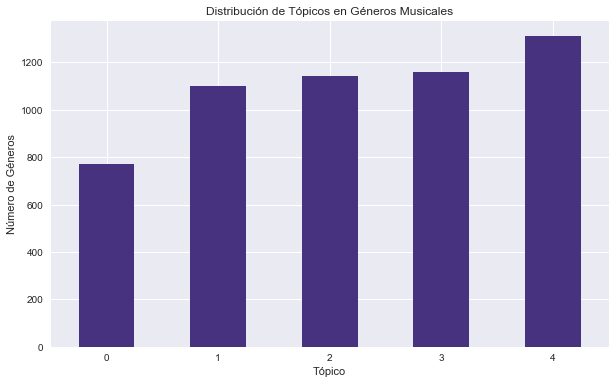

In [31]:
def analyze_genre_topics(df, n_topics=5):
    """Analiza composición de géneros musicales usando modelado de tópicos."""
    
    # Preparar datos (combinar géneros similares)
    genres_text = df['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    
    # Vectorización TF-IDF
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    genres_tfidf = tfidf.fit_transform(genres_text)
    
    # Modelado de tópicos con LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(genres_tfidf)
    
    # Mostrar palabras clave por tópico
    feature_names = tfidf.get_feature_names_out()
    
    print("\nComposición de tópicos para géneros musicales:")
    for topic_idx, topic in enumerate(lda.components_):
        print(f"\nTópico #{topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
    
    # Asignar tópicos a géneros
    df['topic'] = lda.transform(genres_tfidf).argmax(axis=1)
    
    # Visualizar distribución de tópicos
    plt.figure(figsize=(10, 6))
    df['topic'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribución de Tópicos en Géneros Musicales')
    plt.xlabel('Tópico')
    plt.ylabel('Número de Géneros')
    plt.xticks(rotation=0)
    plt.show()
    
    return lda, df

# Aplicar a datos de géneros
if 'genres' in artist_pop.columns:
    lda_model, genres_with_topics = analyze_genre_topics(artist_pop)

In [32]:
# Ejemplo 1: Clustering de todas las canciones
print("=== CLUSTERING DE TODAS LAS CANCIONES ===")
data_clustered, kmeans_model = perform_clustering(pop, hue_column='mode')

# Ejemplo 2: Clustering por géneros (top 5)
print("\n=== CLUSTERING POR GÉNEROS (TOP 5) ===")
top_genres = artist_pop['genres'].value_counts().head(5).index
genre_subset = artist_pop[artist_pop['genres'].isin(top_genres)]
genre_clustered, _ = perform_clustering(genre_subset, hue_column='genres')


=== CLUSTERING DE TODAS LAS CANCIONES ===


NameError: name 'perform_clustering' is not defined

In [35]:
# 1. Entrenamiento con clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [36]:

# Dataset sin etiquetas
features = ['energy', 'valence', 'danceability']
X = df_train[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_train['cluster'] = clusters  # asignar cluster a cada canción


NameError: name 'df_train' is not defined

In [37]:
# Leer el archivo CSV
df = pd.read_csv('artist_pop.csv')  # Cambia 'tus_datos.csv' por el nombre de tu archivo

# Identificar columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Multiplicar todas las variables numéricas * 100 excepto 'duration_ms'
for col in numeric_cols:
    if col == 'duration_ms':
        df[col] = df[col] / 1000  # convertir a segundos
    else:
        df[col] = df[col] * 100

# Ver los primeros renglones para verificar cambios
print(df.head())

#(Opcional) Guardar el nuevo DataFrame
df.to_csv('artist_pop2.csv', index=False)

                                              genres         artists  \
0  ['boston rock', 'dance rock', 'new romantic', ...    'Til Tuesday   
1                      ['k-pop', 'k-pop girl group']        (G)I-DLE   
2        ['boy band', 'dance pop', 'europop', 'pop']          *NSYNC   
3  ['alternative rock', 'dance rock', 'folk', 'li...  10,000 Maniacs   
4                         ['glitchcore', 'hyperpop']        100 gecs   

   acousticness  danceability  duration_ms  energy  liveness  speechiness  \
0          1100          5600     0.255214    6100      1300          300   
1           100          6400     0.196969    8000      2500          500   
2          1900          6100     0.236775    6900      2000          600   
3          1900          5800     0.236013    5400      2300          400   
4          1600          6200     0.126605    6000      3700         2100   

   valence  popularity  
0     5300      346300  
1     3800      792500  
2     5600      453700  
3   

In [38]:
# Leer el archivo CSV
df = pd.read_csv('pop.csv')  # Cambia 'tus_datos.csv' por el nombre de tu archivo

# Identificar columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Multiplicar todas las variables numéricas * 100 excepto 'duration_ms'
for col in numeric_cols:
    if col == 'duration_ms':
        df[col] = df[col] / 1000  # convertir a segundos
    else:
        df[col] = df[col] * 100

# Ver los primeros renglones para verificar cambios
print(df.head())

#(Opcional) Guardar el nuevo DataFrame
df.to_csv('pop2.csv', index=False)

            genres  acousticness  danceability  duration_ms      energy  \
0     acoustic pop    4902.35026    5351.08317     0.235380  4764.39922   
1       afghan pop    4106.28571    6517.14286     0.326504  6515.71429   
2          afropop    4366.59746    6258.03213     0.309969  5345.24640   
3     albanian pop      28.70000    6830.00000     0.187106  6650.00000   
4  alternative pop    1100.67832    4550.66258     0.221231  7592.71015   

     liveness  speechiness     valence   popularity  
0  1577.50499    417.70665  3794.15353  531155.0475  
1   874.60714    844.14286  7841.07143  393214.2857  
2  1598.84035    770.84721  6484.71126  413803.4148  
3   839.00000    499.00000  6670.00000  420000.0000  
4  1725.94815    509.04131  5475.57736  376370.9806  
